In [1]:
import fedhex as fx
from fedhex.pretrain import generation as fxgen
from matplotlib import pyplot as plt
import numpy as np

2023-08-25 12:26:47.732426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# List data generation parameters
ndim = 2
sigma = 0.025
ngausx = 5
ngausy = 5
lims = ((0., 1.), (0., 1.))
seed = 0xace1ace1ace1ace1

# Specify generation 'Strategy' for this (gaussian) Generator
# Strategies for gaussian Generators specify the behavior of
# a base covariance matrix that changes over the sample space
strat = fxgen.RepeatStrategy(fxgen.DiagCov(ndim=ndim, sigma=sigma))

In [3]:
# Make a data generator instance for the specified gaussians
ggg = fx.GridGaussGenerator(cov_strat=strat, ngausx=ngausx,
                               ngausy=ngausy, seed=seed, lims=lims)

In [4]:
nsamp = 1000
samples, labels = ggg.generate(nsamp=nsamp)

In [5]:
data, cond = ggg.preproc()

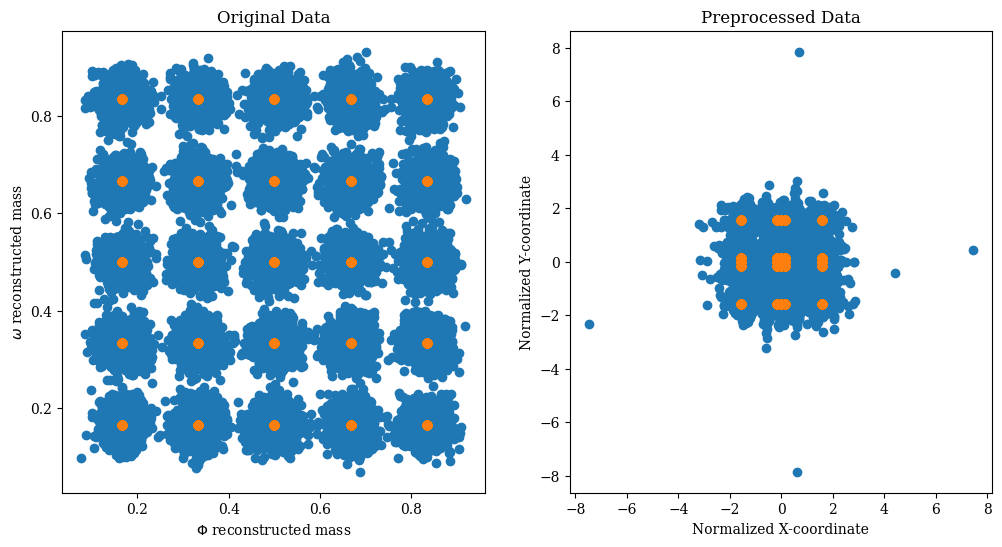

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

ax1.scatter(samples[:,0], samples[:,1])
ax1.scatter(labels[:,0], labels[:,1])
ax1.set_title("Original Data")
ax1.set_xlabel(r"$\Phi$ reconstructed mass")
ax1.set_ylabel(r"$\omega$ reconstructed mass")

ax2.scatter(data[:,0], data[:,1])
ax2.scatter(cond[:,0], cond[:,1])
ax2.set_title("Preprocessed Data")
ax2.set_xlabel("Normalized X-coordinate")
ax2.set_ylabel("Normalized Y-coordinate")
pass

In [7]:
nmade = 10
ninputs = 2
ncinputs = 2
hidden_layers = 1
hidden_units = 128
lr_tuple = (1e-3, 1e-4, 100)
mm = fx.MADEManager(nmade=nmade, ninputs=ninputs, ncinputs=ncinputs,
                    hidden_layers=hidden_layers, hidden_units=hidden_units,
                    lr_tuple=lr_tuple)

In [8]:
mm.compile_model()

In [9]:
starting_epoch = 0
end_epoch = 200
batch_size = 1024
flow_path = "./model/08-24_tut_root/"
loss_path = flow_path + "loss.npy"

In [10]:
from fedhex.train import Checkpointer, EpochLossHistory, SelectiveProgbarLogger

callbacks = []

save_freq = 50 * batch_size
callbacks.append(Checkpointer(filepath=flow_path, save_freq=save_freq))

callbacks.append(EpochLossHistory(loss_path=loss_path))

log_freq = 10
callbacks.append(SelectiveProgbarLogger(1, epoch_interval=log_freq, epoch_end=end_epoch))

In [11]:
mm.train_model(data=data, cond=cond, batch_size=batch_size,
               starting_epoch=starting_epoch, end_epoch=end_epoch,
               path=flow_path, callbacks=callbacks)

12:26:59.20 <I> [Training begins]
epoch begin: 2023-08-25 12:27:11.893897 | time elapsed: 0:00:12.618392
Epoch 10/200
25/25 [==============================] - 0s 18ms/sample - loss: 1.2703
epoch begin: 2023-08-25 12:27:16.337894 | time elapsed: 0:00:17.062389
Epoch 20/200
25/25 [==============================] - 0s 16ms/sample - loss: 0.1872
epoch begin: 2023-08-25 12:27:20.367435 | time elapsed: 0:00:21.091930
Epoch 30/200
25/25 [==============================] - 0s 20ms/sample - loss: -0.3250
epoch begin: 2023-08-25 12:27:24.384566 | time elapsed: 0:00:25.109061
Epoch 40/200
25/25 [==============================] - 0s 16ms/sample - loss: -0.7390
epoch begin: 2023-08-25 12:27:28.364052 | time elapsed: 0:00:29.088547
Epoch 50/200
25/25 [==============================] - 0s 15ms/sample - loss: -1.0221
epoch begin: 2023-08-25 12:27:32.266681 | time elapsed: 0:00:32.991176
Epoch 60/200
25/25 [==============================] - 0s 15ms/sample - loss: -1.1267
epoch begin: 2023-08-25 12:27:36

INFO:tensorflow:Assets written to: ./model/08-24_tut_root/assets


INFO:tensorflow:Assets written to: ./model/08-24_tut_root/assets


12:28:44.25 <I> [Training ends]
0:01:45.05 <I> [Time elapsed]


In [12]:
ngen = 500
gen_labels_unique = [0.5, 0.5]
gen_labels = np.repeat([gen_labels_unique], ngen, axis=0)
gen_cond = ggg.norm(gen_labels, is_cond=True)

In [13]:
gen_data = mm.eval_model(gen_cond)

In [14]:
gen_samples = ggg.denorm(gen_data, is_cond=True)

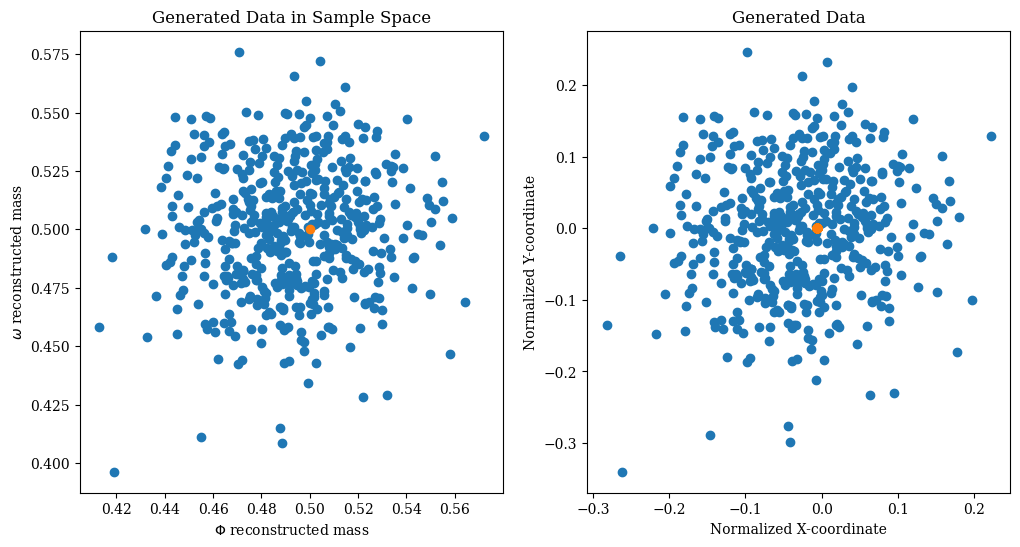

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

ax1.scatter(gen_samples[:,0], gen_samples[:,1])
ax1.scatter(gen_labels_unique[0], gen_labels_unique[1])
ax1.set_title("Generated Data in Sample Space")
ax1.set_xlabel(r"$\Phi$ reconstructed mass")
ax1.set_ylabel(r"$\omega$ reconstructed mass")

ax2.scatter(gen_data[:,0], gen_data[:,1])
ax2.scatter(gen_cond[:,0], gen_cond[:,1])
ax2.set_title("Generated Data")
ax2.set_xlabel("Normalized X-coordinate")
ax2.set_ylabel("Normalized Y-coordinate")
pass